### Look at perseveration: 
- What's the column in object_features look like? 
- Can I define a function to compute it? 


In [23]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
session = "20180802"
path = SESS_BEHAVIOR_PATH.format(sess_name = session)
beh = pd.read_csv(path)
beh = beh[beh.Response.isin(["Correct", "Incorrect"])]
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")

In [26]:
def get_prev_rule(beh):
    group_rules =  beh.groupby("BlockNumber", group_keys=True).apply(lambda group: pd.Series({"CurrentRule": group.CurrentRule.iloc[0]})).reset_index()
    group_rules["PrevRule"] = group_rules["CurrentRule"].shift()
    beh = pd.merge(beh, group_rules[["BlockNumber", "PrevRule"]], on="BlockNumber")
    return beh

In [27]:
beh = get_prev_rule(beh)

In [28]:
beh

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,Item2Shape,Item2Color,Item2Pattern,Item3Shape,Item3Color,Item3Pattern,Color,Shape,Pattern,PrevRule
0,0,0,0,NaN,5276,Correct,0.0,1,RIPPLE,NaN,...,CIRCLE,CYAN,ESCHER,SQUARE,MAGENTA,SWIRL,YELLOW,TRIANGLE,RIPPLE,None
1,1,0,1,NaN,5628,Correct,0.0,1,RIPPLE,NaN,...,TRIANGLE,YELLOW,ESCHER,CIRCLE,GREEN,SWIRL,CYAN,SQUARE,RIPPLE,None
2,2,0,2,NaN,5752,Correct,0.0,1,RIPPLE,NaN,...,STAR,CYAN,ESCHER,CIRCLE,YELLOW,SWIRL,GREEN,SQUARE,RIPPLE,None
3,3,0,3,NaN,5691,Correct,0.0,1,RIPPLE,NaN,...,CIRCLE,GREEN,ESCHER,TRIANGLE,CYAN,SWIRL,YELLOW,SQUARE,RIPPLE,None
4,4,0,4,NaN,5523,Correct,0.0,1,RIPPLE,NaN,...,SQUARE,GREEN,ESCHER,TRIANGLE,CYAN,SWIRL,MAGENTA,STAR,RIPPLE,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1745,55,2,NaN,3908,Correct,0.0,6,YELLOW,GREEN,...,TRIANGLE,MAGENTA,RIPPLE,STAR,GREEN,ESCHER,YELLOW,SQUARE,POLKADOT,GREEN
1745,1746,55,3,NaN,3520,Incorrect,2.0,6,YELLOW,GREEN,...,SQUARE,MAGENTA,POLKADOT,STAR,GREEN,SWIRL,MAGENTA,SQUARE,POLKADOT,GREEN
1746,1747,55,4,NaN,3711,Correct,0.0,6,YELLOW,GREEN,...,STAR,MAGENTA,ESCHER,TRIANGLE,GREEN,POLKADOT,YELLOW,CIRCLE,SWIRL,GREEN
1747,1748,55,5,NaN,3524,Incorrect,1.0,6,YELLOW,GREEN,...,STAR,MAGENTA,POLKADOT,SQUARE,GREEN,ESCHER,CYAN,CIRCLE,SWIRL,GREEN


In [29]:
beh["Perseveration"] = beh.apply(lambda row: row[FEATURE_TO_DIM[row["PrevRule"]]] == row["PrevRule"] if row["PrevRule"] else False, axis=1)

In [33]:
beh[beh.BlockNumber == 3].Perseveration

57     True
58     True
59     True
60     True
61    False
62    False
63    False
64     True
65    False
66    False
67    False
68    False
69    False
70    False
71    False
72    False
73    False
74    False
75    False
76    False
77    False
78    False
79    False
80    False
81    False
82    False
83    False
84    False
85    False
86    False
87    False
88    False
89    False
90    False
91    False
92    False
93    False
94    False
Name: Perseveration, dtype: bool

In [34]:
def get_prob_perseveration_by_block_pos(beh, max_block_pos):
    """
    get probability of choosing correct as a function of position in block
    """
    def get_block_lengths(block):
        block["BlockLength"] = len(block)
        block["TrialInBlock"] = range(len(block))
        return block
    beh = beh.groupby("BlockNumber", group_keys=False).apply(get_block_lengths).reset_index()
    beh = beh[beh.TrialInBlock < max_block_pos]
    def calc_prob_perseverate(group):
        return len(group[group.Perseveration]) / len(group)
    prob_correct = beh.groupby("TrialInBlock", group_keys=False).apply(calc_prob_perseverate).reset_index(name='ProbPerseverate')
    return prob_correct

In [38]:
perseverate_by_trial = get_prob_perseveration_by_block_pos(beh, 15)


<Axes: xlabel='TrialInBlock', ylabel='ProbPerseverate'>

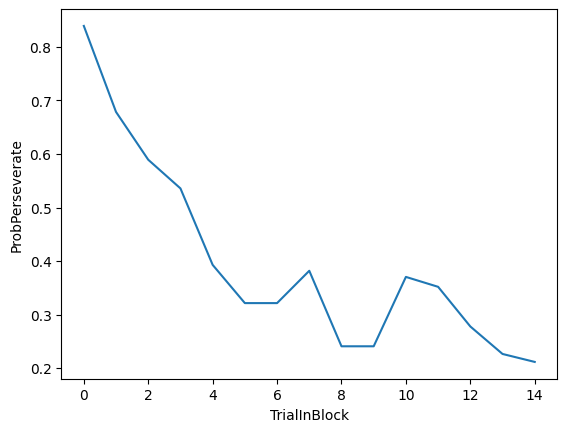

In [39]:
sns.lineplot(perseverate_by_trial, x="TrialInBlock", y="ProbPerseverate")